In [ ]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'
import pickle
import ast
import numpy as np

print("Importing JAX")
import jax
import jax.numpy as jnp
print("Importing JAX successful")

print(f"Checking for CUDA: JAX devices {jax.devices()}")

from jimgw.jim import Jim
from jimgw.single_event.detector import H1, L1, V1, GroundBased2G
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.waveform import RippleIMRPhenomPv2
jax.config.update("jax_enable_x64", True)

# Fetch bilby_pipe DataDump
event_id = "GW190408_181802"
file = os.listdir("bilby_runs/outdir/{}/data".format(event_id))[0]
with open(f"bilby_runs/outdir/{event_id}/data/{file}", "rb") as f:
    data_dump = pickle.load(f)
Mc_lower = float(data_dump.priors_dict['chirp_mass'].minimum)
Mc_upper = float(data_dump.priors_dict['chirp_mass'].maximum)

print(f"Setting the Mc bounds to be {Mc_lower} and {Mc_upper}")

dL_upper = float(data_dump.priors_dict['luminosity_distance'].maximum)
print(f"The dL upper bound is {dL_upper}")

duration = float(data_dump.interferometers[0].strain_data.time_array[-1] - data_dump.interferometers[0].strain_data.time_array[0])
post_trigger = float(data_dump.meta_data['command_line_args']['post_trigger_duration'])
gps = float(data_dump.trigger_time)
fmin: dict[str, float] = data_dump.meta_data['command_line_args']['minimum_frequency']
fmax: dict[str, float] = data_dump.meta_data['command_line_args']['maximum_frequency']

try:
    fmin = float(np.min(list(ast.literal_eval(fmin).values())))
except AttributeError:
    fmin = float(fmin)
try:
    fmax = float(np.min(list(ast.literal_eval(fmax).values())))
except AttributeError:
    fmax = float(fmax)

ifos_list_string = data_dump.interferometers.meta_data.keys()

# Load the HDF5 files from the ifos dict url and open it:
ifos: list[GroundBased2G] = []
for i, ifo_string in enumerate(ifos_list_string):

    ifo_bilby = data_dump.interferometers[i]
    assert ifo_bilby.name == ifo_string, f"ifo_bilby.name: {ifo_bilby.name} != ifo_string: {ifo_string}"

    print("Adding interferometer ", ifo_string)
    eval(f'ifos.append({ifo_string})')

    frequencies, data, psd = ifo_bilby.frequency_array, ifo_bilby.frequency_domain_strain, ifo_bilby.power_spectral_density_array
    
    mask = (frequencies >= fmin) & (frequencies <= fmax)
    frequencies = frequencies[mask]
    data = data[mask]
    psd = psd[mask]

    ifos[i].frequencies = frequencies
    ifos[i].data = data
    ifos[i].psd = psd

waveform = RippleIMRPhenomPv2(f_ref=float(data_dump.meta_data['command_line_args']['reference_frequency']))

likelihood = TransientLikelihoodFD(
    ifos, waveform=waveform, trigger_time=gps, duration=duration, post_trigger_duration=post_trigger
)

Importing JAX
Importing JAX successful
Checking for CUDA: JAX devices [CpuDevice(id=0)]


/home/thomas.ng/.conda/envs/jim/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


Setting the Mc bounds to be 26.700411297080883 and 96.67976382167427
The dL upper bound is 10000.0
Adding interferometer  H1
Adding interferometer  L1


In [2]:
from bilby.gw.result import CBCResult

result_bilby = CBCResult.from_hdf5(f"bilby_runs/outdir/{event_id}/final_result/"+os.listdir("bilby_runs/outdir/{}/final_result".format(event_id))[0]).posterior
maxL_params_bilby = result_bilby.log_likelihood.idxmax()
maxL_params_bilby = result_bilby.iloc[maxL_params_bilby]
maxL_params_bilby = maxL_params_bilby.to_dict()
maxL_params_bilby.keys()

dict_keys(['H1_log_likelihood', 'H1_matched_filter_snr', 'H1_optimal_snr', 'L1_log_likelihood', 'L1_matched_filter_snr', 'L1_optimal_snr', 'a_1', 'a_2', 'azimuth', 'chi_1_in_plane', 'chi_2_in_plane', 'chi_eff', 'chi_p', 'chirp_mass', 'chirp_mass_source', 'comoving_distance', 'cos_tilt_1', 'cos_tilt_2', 'dec', 'geocent_time', 'iota', 'log_likelihood', 'log_prior', 'luminosity_distance', 'mass_1', 'mass_1_source', 'mass_2', 'mass_2_source', 'mass_ratio', 'minimum_frequency', 'phase', 'phi_1', 'phi_12', 'phi_2', 'phi_jl', 'psi', 'ra', 'redshift', 'reference_frequency', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y', 'spin_2z', 'symmetric_mass_ratio', 'theta_jn', 'tilt_1', 'tilt_2', 'time_jitter', 'total_mass', 'total_mass_source', 'waveform_approximant', 'zenith'])

In [3]:
# params_bilby = {}
# params_bilby["M_c"] = maxL_params_bilby["chirp_mass"]
# params_bilby["eta"] = maxL_params_bilby["symmetric_mass_ratio"]
# params_bilby["s1_x"] = maxL_params_bilby["spin_1x"]
# params_bilby["s1_y"] = maxL_params_bilby["spin_1y"]
# params_bilby["s1_z"] = maxL_params_bilby["spin_1z"]
# params_bilby["s2_x"] = maxL_params_bilby["spin_2x"]
# params_bilby["s2_y"] = maxL_params_bilby["spin_2y"]
# params_bilby["s2_z"] = maxL_params_bilby["spin_2z"]
# params_bilby["iota"] = maxL_params_bilby["iota"]
# params_bilby["d_L"] = maxL_params_bilby["luminosity_distance"]
# params_bilby["t_c"] = maxL_params_bilby["geocent_time"] - gps
# params_bilby["phase_c"] = maxL_params_bilby["phase"]
# params_bilby["psi"] = maxL_params_bilby["psi"]
# params_bilby["ra"] = maxL_params_bilby["ra"]
# params_bilby["dec"] = maxL_params_bilby["dec"]
# # dict(sorted(params_bilby.items()))

# maxL_bilby = likelihood.evaluate(params_bilby, None)
# print("Bilby maxL:", maxL_bilby)

# result_jim = jnp.load(f'jim_runs/outdir/{event_id}/samples.npz')
# result_jim = dict(result_jim)
# M_c = result_jim["M_c"]

# # M_c_idx = np.where(M_c == np.median(M_c))[0]
# M_c_idx = np.where(np.isclose(M_c, np.median(M_c), atol=0.0000000001))[0]

# maxL_jim = 0
# for i in M_c_idx:
#     params_jim = {}
#     for key in result_jim.keys():
#         params_jim[key] = result_jim[key][i]
#     for transform in likelihood_transforms:
#         params_jim = transform.forward(params_jim)
#     # dict(sorted(params_jim.items()))

#     logL = likelihood.evaluate(params_jim, None)
#     if logL > maxL_jim:
#         maxL_jim = logL
#         best_params_jim = params_jim

# print("Jim median:", maxL_jim)

# print("MaxL Difference:", maxL_bilby - maxL_jim)

In [4]:
import bilby
from bilby.gw.likelihood import GravitationalWaveTransient
from bilby.gw.waveform_generator import WaveformGenerator

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=data_dump.meta_data['command_line_args']['reference_frequency'],
    minimum_frequency=fmin,
)

waveform_generator = WaveformGenerator(
    duration=duration,
    sampling_frequency=data_dump.meta_data['command_line_args']['sampling_frequency'],
    start_time=gps+post_trigger-duration,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

likelihood_bilby = GravitationalWaveTransient(
    interferometers=data_dump.interferometers,
    jitter_time=True, # gives the same result in the following comparison
    reference_frame=data_dump.interferometers,
    waveform_generator=waveform_generator,
)

17:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [5]:
n_samples = 100
samples_bilby = result_bilby.sample(n_samples, random_state=42)

param_list = []
for i in range(n_samples):
    sample = samples_bilby.iloc[i].to_dict()
    likelihood_bilby.parameters = sample
    logL_bilby = likelihood_bilby.log_likelihood_ratio()
    # print("Bilby Likelihood:", logL_bilby)

    params = {}
    params["logL_bilby"] = logL_bilby

    params["M_c"] = sample["chirp_mass"]
    params["eta"] = sample["symmetric_mass_ratio"]
    params["s1_x"] = sample["spin_1x"]
    params["s1_y"] = sample["spin_1y"]
    params["s1_z"] = sample["spin_1z"]
    params["s2_x"] = sample["spin_2x"]
    params["s2_y"] = sample["spin_2y"]
    params["s2_z"] = sample["spin_2z"]
    params["iota"] = sample["iota"]
    params["d_L"] = sample["luminosity_distance"]
    params["t_c"] = sample["geocent_time"] - gps
    params["phase_c"] = sample["phase"]
    params["psi"] = sample["psi"]
    params["ra"] = sample["ra"]
    params["dec"] = sample["dec"]

    logL_jim = likelihood.evaluate(params, None)
    # print("Jim Likelihood:", logL_jim)

    params["logL_jim"] = logL_jim
    param_list.append(params)

    # print("Difference:", logL_bilby - logL_jim)
    # print()

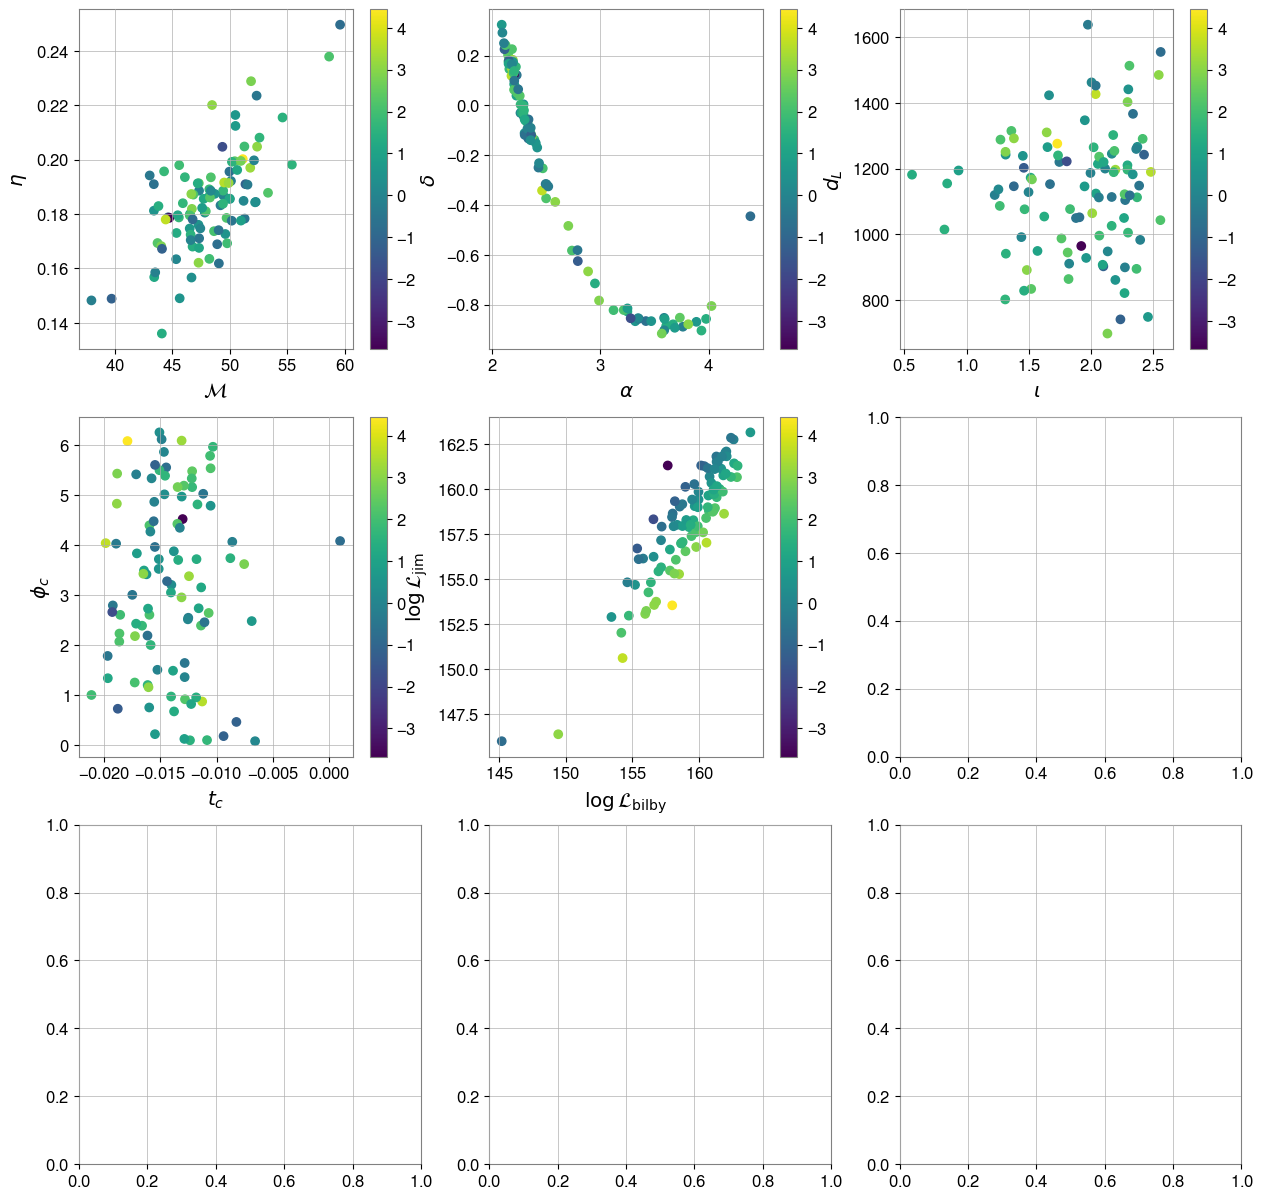

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plotting the difference in likelihoods
axs[0, 0].scatter([x["M_c"] for x in param_list], [x["eta"] for x in param_list], c=[x["logL_bilby"] - x["logL_jim"] for x in param_list])
axs[0, 0].set_xlabel(r"$\mathcal{M}$")
axs[0, 0].set_ylabel(r"$\eta$")
fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

axs[0, 1].scatter([x["ra"] for x in param_list], [x["dec"] for x in param_list], c=[x["logL_bilby"] - x["logL_jim"] for x in param_list])
axs[0, 1].set_xlabel(r"$\alpha$")
axs[0, 1].set_ylabel(r"$\delta$")
fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

axs[0, 2].scatter([x["iota"] for x in param_list], [x["d_L"] for x in param_list], c=[x["logL_bilby"] - x["logL_jim"] for x in param_list])
axs[0, 2].set_xlabel(r"$\iota$")
axs[0, 2].set_ylabel(r"$d_L$")
fig.colorbar(axs[0, 2].collections[0], ax=axs[0, 2])\

axs[1, 0].scatter([x["t_c"] for x in param_list], [x["phase_c"] for x in param_list], c=[x["logL_bilby"] - x["logL_jim"] for x in param_list])
axs[1, 0].set_xlabel(r"$t_c$")
axs[1, 0].set_ylabel(r"$\phi_c$")
fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

axs[1, 1].scatter([x["logL_bilby"] for x in param_list], [x["logL_jim"] for x in param_list], c=[x["logL_bilby"] - x["logL_jim"] for x in param_list])
axs[1, 1].set_xlabel(r"$\log\mathcal{L}_{\text{bilby}}$")
axs[1, 1].set_ylabel(r"$\log\mathcal{L}_{\text{jim}}$")
fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

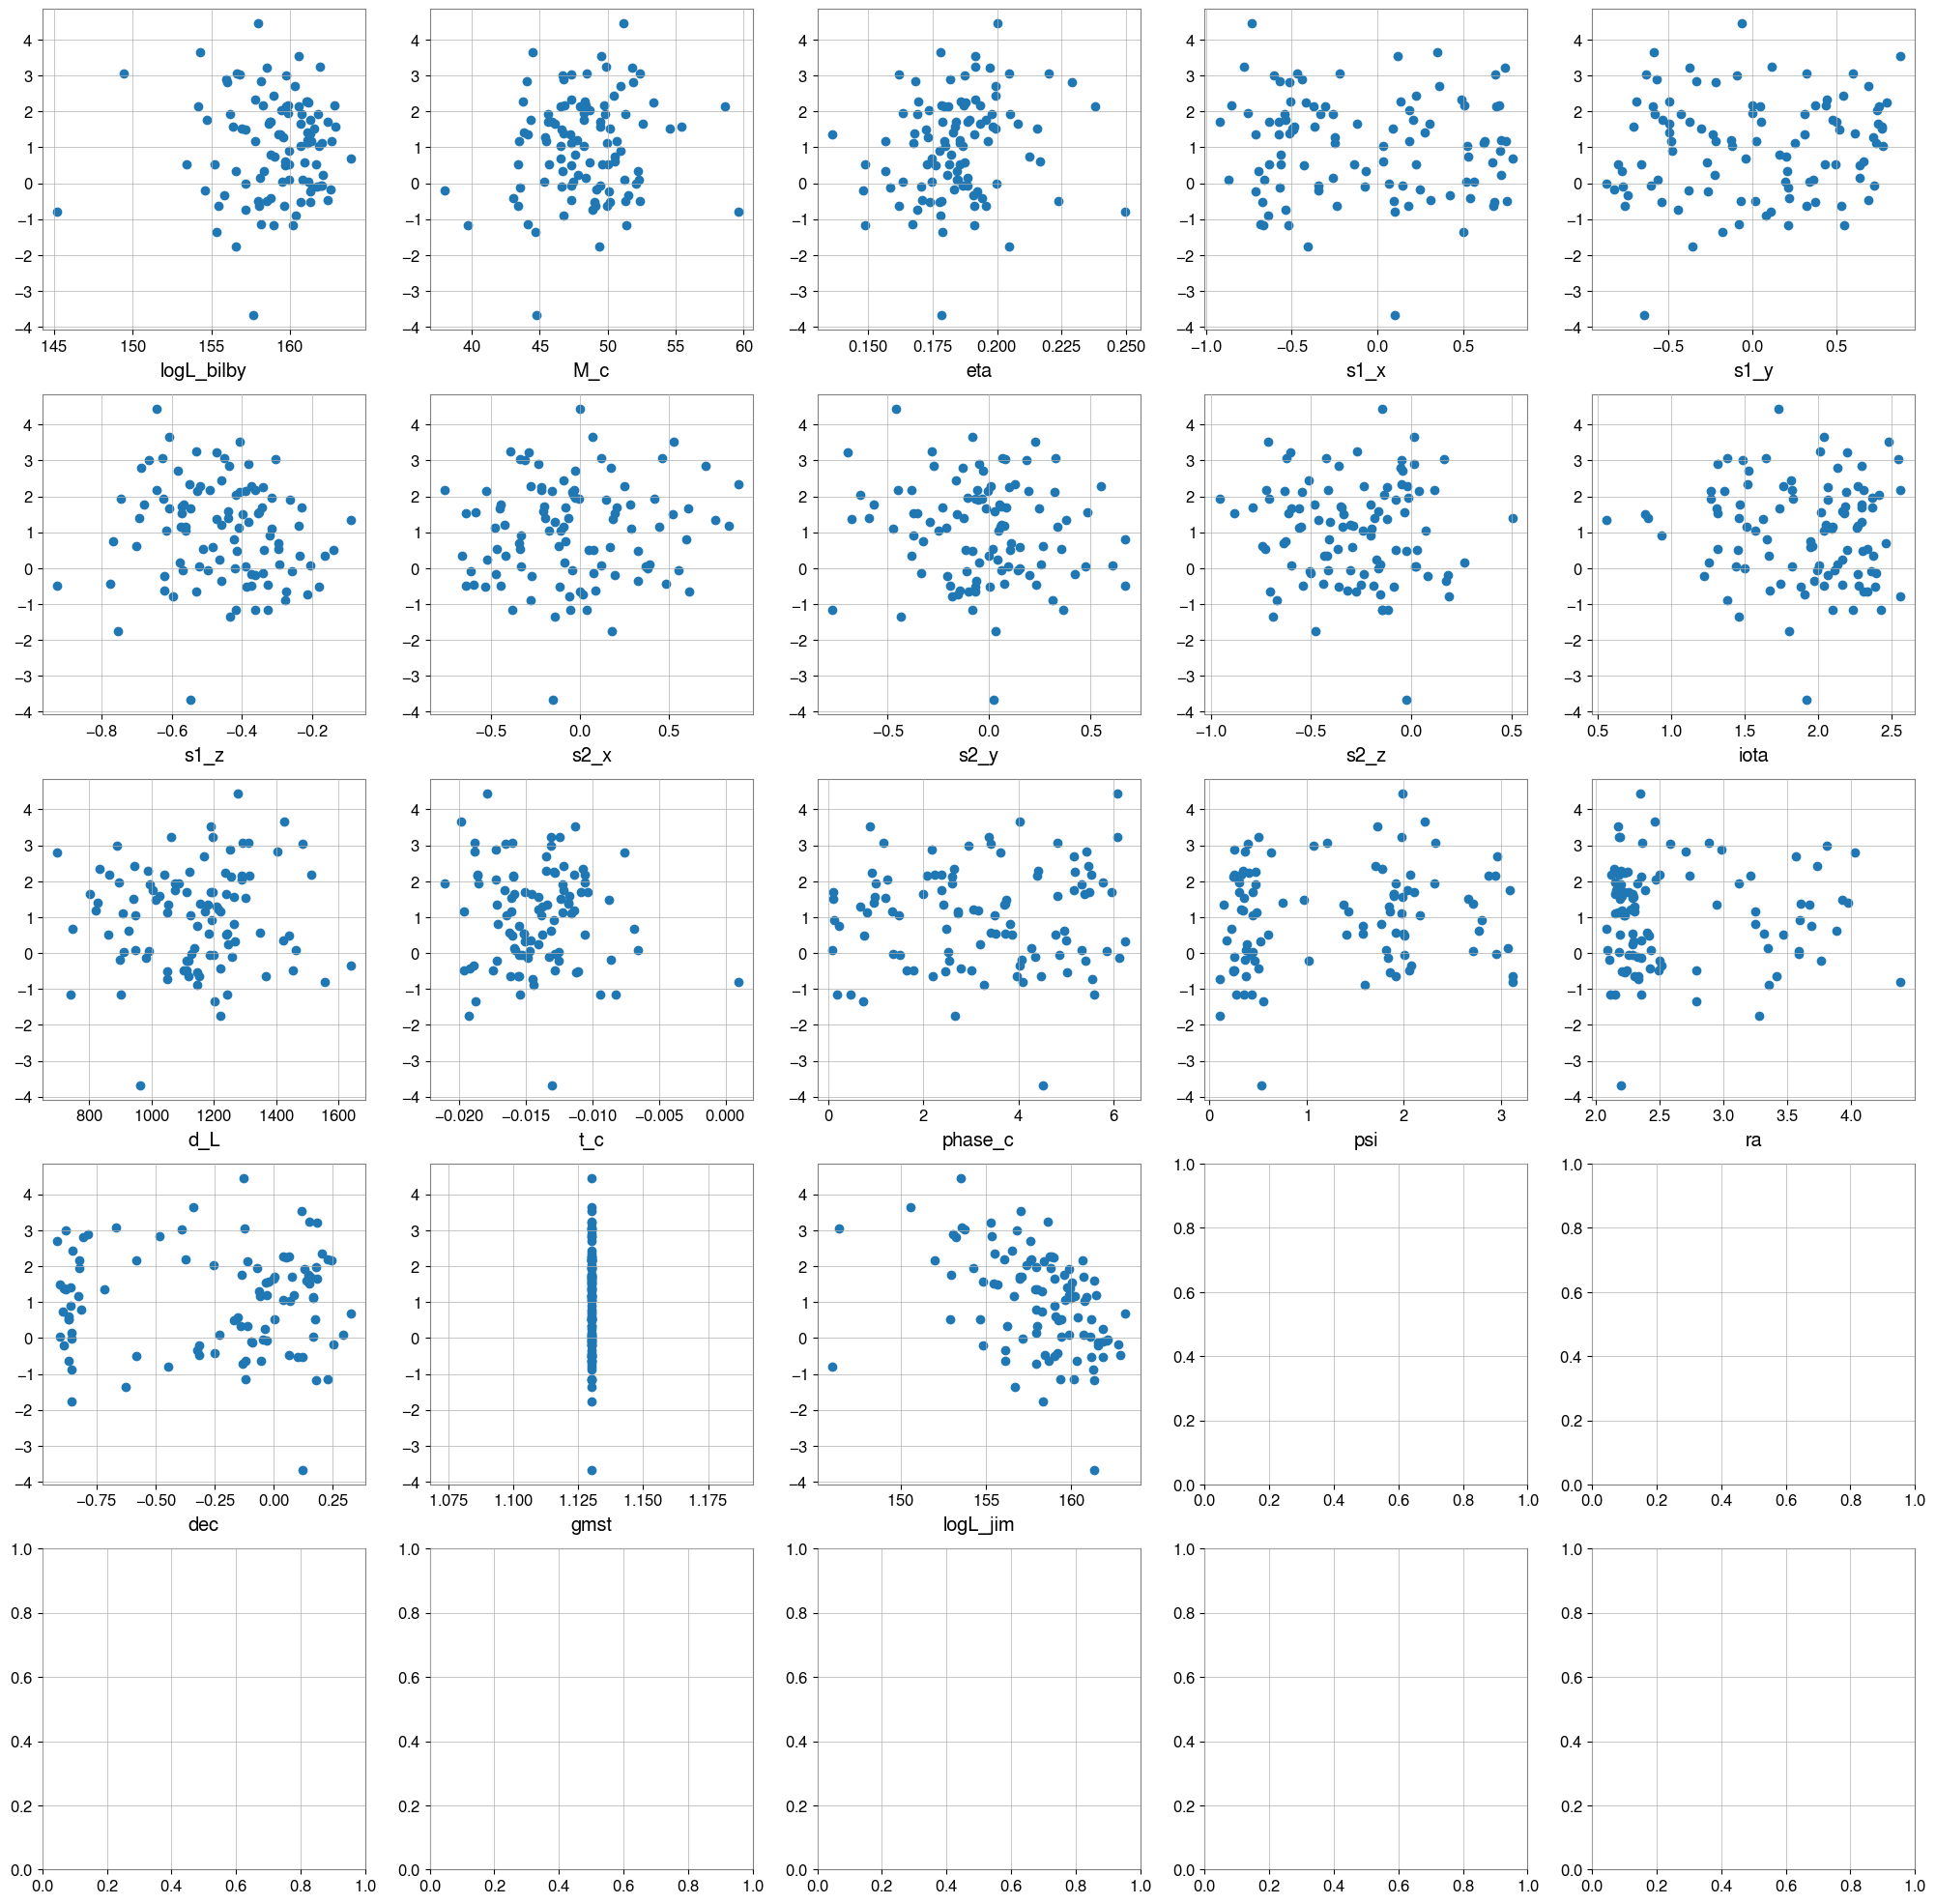

In [7]:
fig, Axes = plt.subplots(5, 5, figsize=(25, 25))

axes = Axes.flatten()
for i, key in enumerate(param_list[0].keys()):
    axes[i].scatter([x[key] for x in param_list], [x["logL_bilby"] - x["logL_jim"] for x in param_list])
    axes[i].set_xlabel(key)

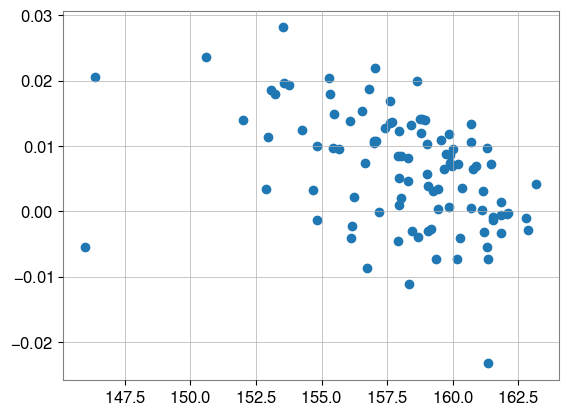

In [8]:
plt.scatter([x["logL_jim"] for x in param_list], [1 - x["logL_jim"]/x["logL_bilby"] for x in param_list])